In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from skimage.color import rgb2gray
from skimage.draw import disk
from matplotlib.patches import Circle

# Data import

In [3]:
path_data = "./examples/series_01.csv"
df = pd.read_csv(path_data)
print(df.shape[0])
#df.head()

# open image
image = Image.open("./examples/series_01.jpg").convert("RGB")

816


## Draw circle area

In [4]:
# convert RGB → grayscale
gray = rgb2gray(image)

orig_size=(2560, 2560)
pixel_size_original_nm=16.0

jpg_w, jpg_h = image.size
orig_w, orig_h = orig_size

# scaling from original px -> current image px
sx = jpg_w / orig_w
sy = jpg_h / orig_h

H, W = image.size

x_list = []
y_list = []
sigma_list = []
mean_list = []

for _, row in df.iterrows():
    x_nm = row["x [nm]"]
    y_nm = row["y [nm]"]
    sigma_nm = row["sigma [nm]"]

    # nm -> original pixels
    x_orig_px = x_nm / pixel_size_original_nm
    y_orig_px = y_nm / pixel_size_original_nm
    sigma_orig_px = sigma_nm / pixel_size_original_nm

    # original pixels -> current image pixels
    x_px = int(round(x_orig_px * sx))
    y_px = int(round(y_orig_px * sy))
    sigma_px= int(round(sigma_orig_px * sx))

    # --- build circular mask (clipped to image) ---
    rr, cc = disk((y_px, x_px), sigma_px, shape=(H, W))  # (row=y, col=x)
    mask = np.zeros((H, W), dtype=bool)
    mask[rr, cc] = True

    # --- mean intensity in ROI ---
    mean_intensity = gray[mask].mean()

    # store values
    x_list.append(x_px)
    y_list.append(y_px)
    sigma_list.append(sigma_px)
    mean_list.append(mean_intensity)

# add new columns
df["x_px"] = x_list
df["y_px"] = y_list
df["sigma_px"] = sigma_list
df["mean_intensity"] = mean_list


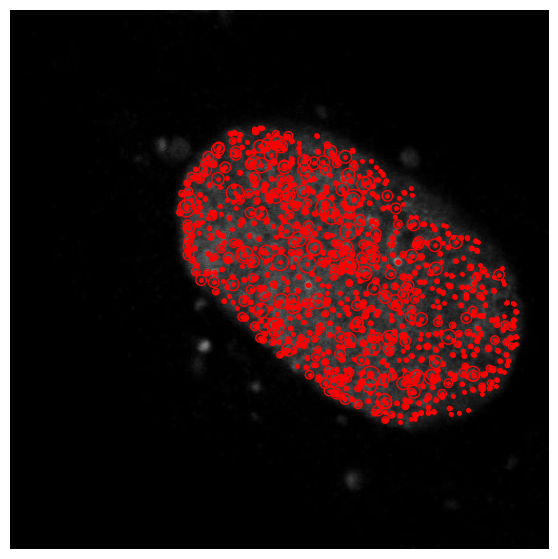

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(df["x_px"], df["y_px"], df["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

In [7]:
df.head()

,id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm],x_px,y_px,sigma_px,mean_intensity
0,1,12886.03135,15329.57455,253.18023,9360.30665,6.52939,161,192,3,0.161608
1,2,13073.14426,13939.38825,271.41933,8359.28749,5.31591,163,174,3,0.138766
2,3,13387.79332,14910.78254,444.07739,31480.11359,5.74411,167,186,6,0.184923
3,4,13450.54301,16265.82093,291.43137,7083.19266,11.65476,168,203,4,0.190014
4,5,13495.59220,16593.38287,406.55681,28835.37203,6.02487,169,207,5,0.211512


In [15]:
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)
    
    plt.xlabel(x_col.replace("_", " "))
    plt.ylabel(y_col.replace("_", " "))
    
    plt.tight_layout()
    plt.show()

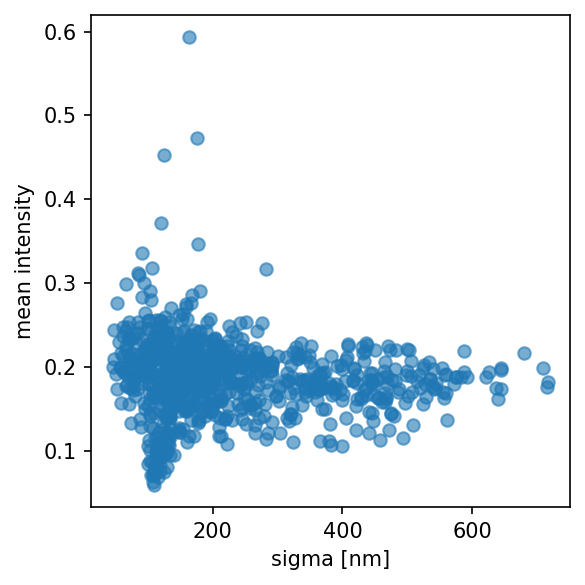

In [16]:
scatter_plot(df, "sigma [nm]", "mean_intensity")

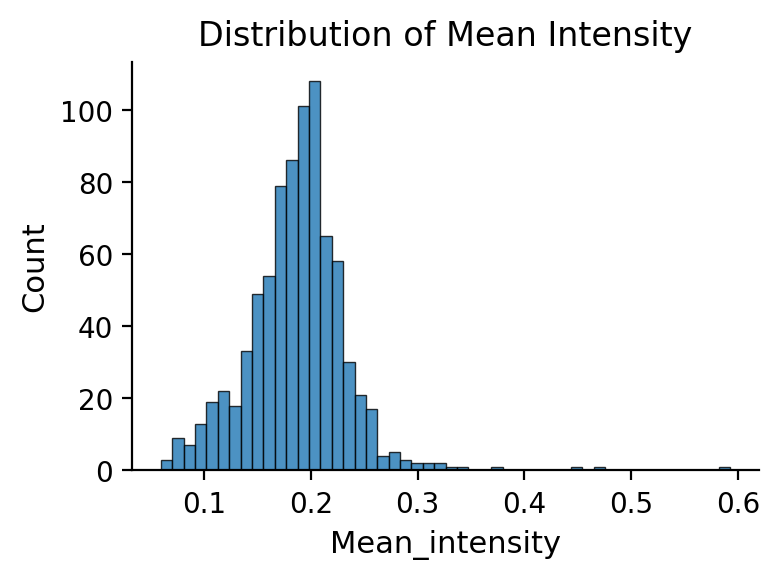

In [13]:
plt.figure(figsize=(4, 3), dpi=200)

plt.hist(
    df["mean_intensity"],
    bins=50,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)

plt.xlabel("Mean_intensity", fontsize=11)
plt.ylabel("Count", fontsize=11)
plt.title("Distribution of Mean Intensity", fontsize=12)

# Remove top/right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


Cluster centers: [np.float64(159.07190661264175), np.float64(436.96237502512554)]
Threshold: 298.01714081888366


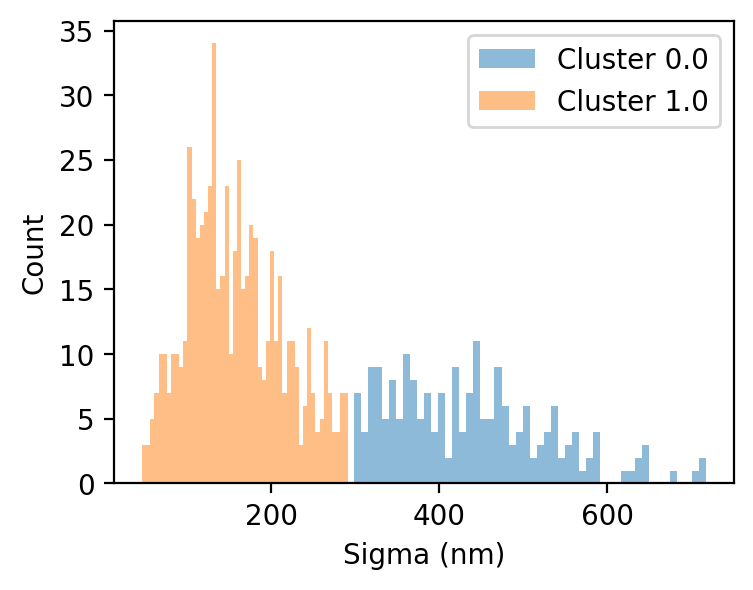

In [10]:
X = df[["sigma [nm]"]]   # must stay 2D for sklearn
X = df[["sigma [nm]"]].dropna()

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
df.loc[X.index, "cluster"] = labels

# Threshold
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)

print("Cluster centers:", centers)
print("Threshold:", threshold)

# plot
plt.figure(figsize=(4,3), dpi=200)

for cluster in sorted(df["cluster"].dropna().unique()):
    subset = df[df["cluster"] == cluster]
    plt.hist(subset["sigma [nm]"], bins=50, alpha=0.5, label=f"Cluster {cluster}")

plt.xlabel("Sigma (nm)")
plt.ylabel("Count")
plt.legend()

plt.show()



In [ ]:
scatter_plot(df, "sigma [nm]", "intensity [photon]")

Task:
1. sigma - 2 populations (KMeans)
2. Outliers of sigma - check them:
 - big bright dots: analyze as a third population
 - aggregates: analyze separatly
 - MFI of nucleus - big dots/aggregates
3. How the bg susbstruction affects the sigma, MFI of foci?

In [ ]:
means = df.groupby("sigma [nm]")["intensity [photon]"].mean()
plt.bar(means.index, means.values)
plt.xlabel("sigma [nm]")
plt.ylabel("Mean intensity [photon]")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Select two columns
n_clusters = 2
X = df[["sigma [nm]", "intensity [photon]"]].dropna()

# Run clustering (choose number of clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_
sigma_centers = centers[:, 0]
intensity_centers = centers[:, 1]
print("Cluster centers (sigma [nm], intensity [photon]):")
for i in range(len(sigma_centers)):
    print(f"Cluster {i}: ({sigma_centers[i]:.2f}, {intensity_centers[i]:.2f})")

# Plot result
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
plt.xlabel("sigma [nm]")
plt.ylabel("intensity [photon]")
plt.show()

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])